# Impute missing value by sample with replacement VS. Leave as "missing_value"

In [82]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [83]:
url = "https://drive.google.com/uc?export=download&id=1TC0m9YsNwTuj7UFyI5M02k7V0nGgh0tZ"
data = pd.read_csv(url)


In [84]:
data.describe(include='all')
#about 25000 missing values in country

,country,age,is_mobile,source,converted
count,95502,120704.000000,120704.000000,120704,120704.000000
unique,3,NaN,NaN,3,NaN
top,UK,NaN,NaN,Seo,NaN
freq,69626,NaN,NaN,59324,NaN
mean,NaN,44.575258,0.631006,NaN,0.169845
std,NaN,11.661944,0.482534,NaN,0.375498
min,NaN,17.000000,0.000000,NaN,0.000000
25%,NaN,36.000000,0.000000,NaN,0.000000
50%,NaN,44.000000,1.000000,NaN,0.000000
75%,NaN,53.000000,1.000000,NaN,0.000000


## Impute missing value by sample with replacement

In [85]:
np.random.seed(4684)

data_replace= data.copy()

#split into train & test
train, test = train_test_split(data_replace,
                               test_size=0.34)

train = train.reset_index(drop = True).copy()
test = test.reset_index(drop = True).copy()

# replace NA according to original country distribution
train['country'] = train['country'].fillna(pd.Series(np.random.choice(train['country'].dropna(),
                                                                      size = len(train['country']))))
test['country'] = test['country'].fillna(pd.Series(np.random.choice(test['country'].dropna(),
                                                                    size= len(test['country']))))

#create dummies
train = pd.get_dummies(train, drop_first=True)
test = pd.get_dummies(test,drop_first=True)



In [86]:
#build RF model
rf1 = RandomForestClassifier(n_estimators=50,
                             oob_score=True,
                             class_weight={0:1,1:5})

# n_estimators=50: This sets the number of trees in the forest to 50. A larger number of trees can improve the model's performance but will also increase the training time.
# oob_score=True: This enables the use of out-of-bag (OOB) samples to estimate the generalization accuracy. OOB samples are those not included in the bootstrap sample for training a particular tree. Using OOB samples for validation helps in assessing the performance without the need for a separate validation set.
# class_weight={0:1, 1:5}: This parameter is used to handle imbalanced classes by assigning different weights to different classes. In this case, class 0 has a weight of 1, and class 1 has a weight of 5. This means that the classifier will pay five times more attention to class 1 compared to class 0, which is useful when class 1 is underrepresented in the dataset.

X_train = train.drop('converted', axis =1)
y_train = train['converted']

rf1.fit(X_train, y_train)

# test confusion matrix
conf_matrix_sampling = pd.DataFrame(confusion_matrix(test['converted'],
                                                     rf1.predict(test.drop('converted', axis=1)),
                                                     labels=[0, 1]
                                                     ))

print(conf_matrix_sampling)


       0      1
0  23926  10233
1   2040   4841


In [87]:
type1_error = conf_matrix_sampling.loc[0,1]/ (conf_matrix_sampling.loc[0,0] + conf_matrix_sampling.loc[0,1])
print("type 1 error:",round(type1_error,2))

type2_error = conf_matrix_sampling.loc[1,0]/ (conf_matrix_sampling.loc[1,0] + conf_matrix_sampling.loc[1,1])
print("type 2 error:",round(type2_error,2))

accuracy = (conf_matrix_sampling.loc[0,0] + conf_matrix_sampling.loc[1,1]) / len(test)
print("accuracy:",round(accuracy,2))

type 1 error: 0.3
type 2 error: 0.3
accuracy: 0.7


<Axes: >

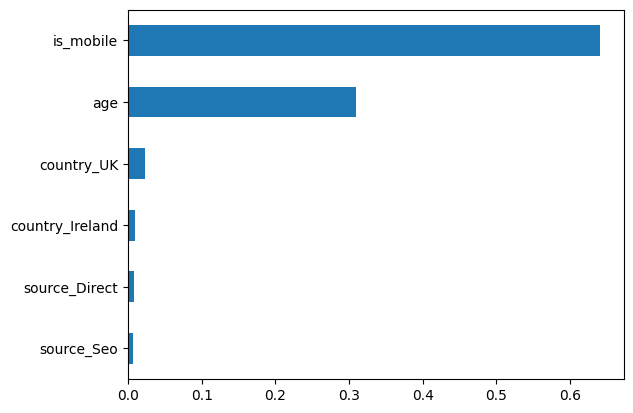

In [88]:
#variable importance
feature_importances = rf1.feature_importances_
# print(feature_importances)

feature_names = X_train.columns
# print(feature_names)

importance_series = pd.Series(feature_importances,index=feature_names).sort_values(ascending=True)
# print(importance_series)

importance_series.plot(kind = 'barh')

## Leave as "missing_value"

In [89]:
np.random.seed(4684)

data_leave= data.copy()

#split into train & test
train, test = train_test_split(data_leave,
                               test_size=0.34)

train = train.reset_index(drop = True).copy()
test = test.reset_index(drop = True).copy()

# replace NA according to original country distribution
train['country'] = train['country'].fillna('missing_country')
test['country'] = test['country'].fillna('missing_country')

#create dummies
train = pd.get_dummies(train, drop_first=True)
test = pd.get_dummies(test,drop_first=True)


In [90]:
rf2 = RandomForestClassifier(n_estimators=50,
                            oob_score=True,
                             class_weight={0:1,1:5})

print(train.describe())
X_train = train.drop('converted',axis= 1)
y_train = train['converted']
# print(X_train,y_train)


X_test = test.drop('converted',axis= 1)
y_test = test['converted']

rf2.fit(X_train,y_train)

conf_matrix_leave = pd.DataFrame(confusion_matrix(y_test,
                                                         rf2.predict(X_test),
                                                         labels =[0,1]))

conf_matrix_leave


                age     is_mobile     converted
count  79664.000000  79664.000000  79664.000000
mean      44.592112      0.630937      0.170968
std       11.676208      0.482554      0.376483
min       17.000000      0.000000      0.000000
25%       36.000000      0.000000      0.000000
50%       44.000000      1.000000      0.000000
75%       53.000000      1.000000      0.000000
max       80.000000      1.000000      1.000000


,0,1
0,25411,8748
1,1788,5093


In [91]:
type1_error = conf_matrix_leave.loc[0,1] / (conf_matrix_leave.loc[0,1] + conf_matrix_leave.loc[0,0])
print("type1_error:", round(type1_error,2))

type2_error = conf_matrix_leave.loc[1,0] / (conf_matrix_leave.loc[1,0] + conf_matrix_leave.loc[1,1])
print("type2_error:", round(type2_error,2))

accuracy = (conf_matrix_leave.loc[0,0] + conf_matrix_leave.loc[1,1]) / len(test)
print("accuracy:", round(accuracy,2))


type1_error: 0.26
type2_error: 0.26
accuracy: 0.74


<Axes: >

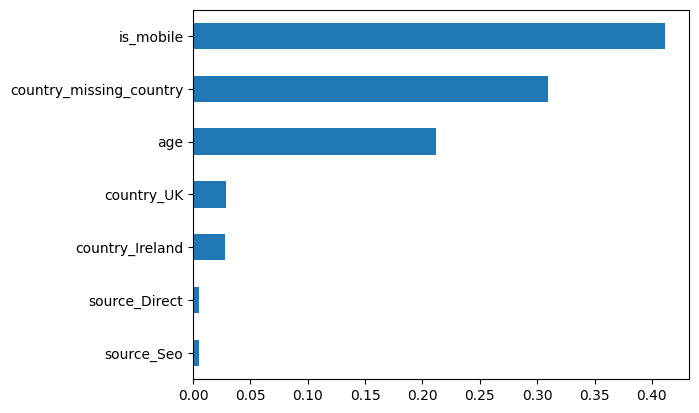

In [92]:
feature_importances = rf2.feature_importances_
# print(feature_importances )
feature_names = X_train.columns

importance_series = pd.Series(feature_importances,
                              index = feature_names).sort_values(ascending=True)
importance_series

importance_series.plot(kind = 'barh')

## Conclusion

missing_country contains important information, as it ranks #2 when we fill missing value as "missing_country". UK and Ireland becomes less important when we do so as well - this is probably because we artificially increased their importance by imputing and filling.

the missing_country model does much better, as demontrated by lower type 1 and type 2 error, and higher accuracy.